件数ピボット（先頭）：
name      Action  Animation  Children  Classics  Comedy  Documentary  Drama  \
store_id                                                                      
1            596        568       453       447     502          450    576   
2            516        598       492       492     439          600    484   

name      Family  Foreign  Games  Horror  Music  New  Sci-Fi  Sports  Travel  
store_id                                                                      
1            557      524    455     386    436  502     521     555     395  
2            539      509    514     460    394  438     580     624     442   



C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33303 (\N{CJK UNIFIED IDEOGRAPH-8217}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages

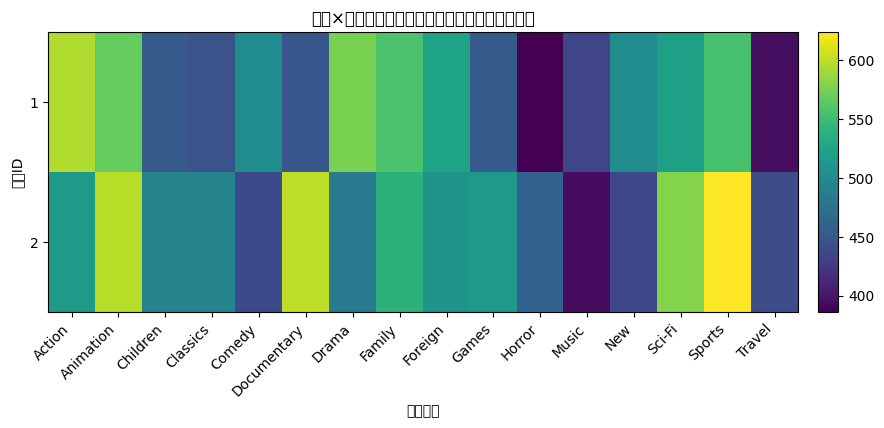

C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33303 (\N{CJK UNIFIED IDEOGRAPH-8217}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\flare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages

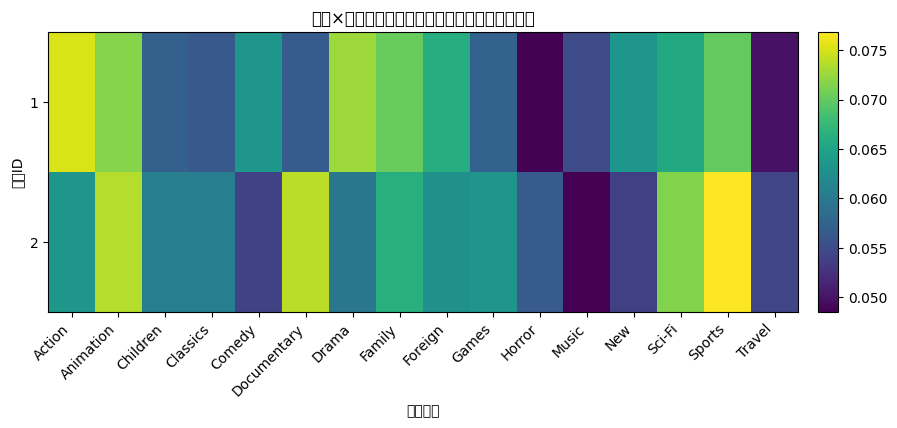

店舗ごとの強いジャンル（上位3）：
 store_id                                top_categories
        1       Action(596), Drama(576), Animation(568)
        2 Sports(624), Documentary(600), Animation(598)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== 入力CSV（相対パスは必要に応じて変更）====
CAT_CSV   = "csv_exports/category.csv"
FC_CSV    = "csv_exports/film_category.csv"
FILM_CSV  = "csv_exports/film.csv"
INV_CSV   = "csv_exports/inventory.csv"
RENT_CSV  = "csv_exports/rental.csv"
PAY_CSV   = "csv_exports/payment.csv"   # 売上を見たい場合に使用（任意）

# ==== 集計（店舗×カテゴリ：レンタル件数）====
def make_store_category_counts():
    cat = pd.read_csv(CAT_CSV)                        # category_id, name
    fc  = pd.read_csv(FC_CSV)                         # film_id, category_id
    film= pd.read_csv(FILM_CSV)                       # film_id, ...
    inv = pd.read_csv(INV_CSV)                        # inventory_id, film_id, store_id
    rent= pd.read_csv(RENT_CSV, parse_dates=["rental_date"])  # rental_id, inventory_id, ...

    # rental -> inventory(店舗, film) -> film_category -> category(名前)
    df = (rent.merge(inv[["inventory_id","film_id","store_id"]], on="inventory_id", how="left")
               .merge(fc, on="film_id", how="left")
               .merge(cat, on="category_id", how="left"))

    # ピボット（件数）
    pt_cnt = pd.pivot_table(df, index="store_id", columns="name",
                            values="rental_id", aggfunc="count", fill_value=0)
    pt_cnt = pt_cnt.sort_index().sort_index(axis=1)
    return pt_cnt

# ==== 参考：売上で見たい場合（店舗×カテゴリ：金額合計）====
def make_store_category_sales():
    cat = pd.read_csv(CAT_CSV)
    fc  = pd.read_csv(FC_CSV)
    inv = pd.read_csv(INV_CSV)
    rent= pd.read_csv(RENT_CSV)
    pay = pd.read_csv(PAY_CSV, parse_dates=["payment_date"])  # amount, rental_id

    # payment -> rental -> inventory(店舗, film) -> film_category -> category
    df = (pay.merge(rent[["rental_id","inventory_id"]], on="rental_id", how="left")
              .merge(inv[["inventory_id","film_id","store_id"]], on="inventory_id", how="left")
              .merge(fc, on="film_id", how="left")
              .merge(cat, on="category_id", how="left"))

    pt_sales = pd.pivot_table(df, index="store_id", columns="name",
                              values="amount", aggfunc="sum", fill_value=0.0)
    pt_sales = pt_sales.sort_index().sort_index(axis=1)
    return pt_sales

# ==== 可視化（matplotlibのみ：色指定なし／単一図）====
def plot_heatmap(table, title="店舗×カテゴリ：レンタル件数（ヒートマップ）"):
    fig = plt.figure(figsize=(10, 4))   # 半分サイズにしたい場合は (5, 2)
    ax = fig.add_axes([0.12, 0.2, 0.75, 0.7])
    im = ax.imshow(table.values, aspect="auto")  # デフォルトカラーマップ

    ax.set_xticks(range(table.shape[1]))
    ax.set_yticks(range(table.shape[0]))
    ax.set_xticklabels(table.columns, rotation=45, ha="right")
    ax.set_yticklabels(table.index)

    ax.set_xlabel("カテゴリ")
    ax.set_ylabel("店舗ID")
    ax.set_title(title)

    # カラーバー
    cax = fig.add_axes([0.89, 0.2, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    plt.show()

# ==== 上位カテゴリ（店舗ごと）をテーブルで表示 ====
def top_categories_per_store(table, top_n=3):
    rows = []
    for store_id, row in table.iterrows():
        top = row.sort_values(ascending=False).head(top_n)
        rows.append({
            "store_id": store_id,
            "top_categories": ", ".join(f"{k}({int(v)})" for k, v in top.items())
        })
    return pd.DataFrame(rows)

if __name__ == "__main__":
    # 1) 件数ヒートマップ
    pt_cnt = make_store_category_counts()
    print("件数ピボット（先頭）：")
    print(pt_cnt.head(), "\n")
    plot_heatmap(pt_cnt, title="店舗×カテゴリ：レンタル件数（ヒートマップ）")

    # 2) 比率ヒートマップ（店舗行で標準化）
    pt_ratio = pt_cnt.div(pt_cnt.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    plot_heatmap(pt_ratio, title="店舗×カテゴリ：レンタル比率（ヒートマップ）")

    # 3) 店舗ごとの強いジャンル（上位3）
    tops = top_categories_per_store(pt_cnt, top_n=3)
    print("店舗ごとの強いジャンル（上位3）：")
    print(tops.to_string(index=False))


件数ピボット（先頭5行）：
name      Action  Animation  Children  Classics  Comedy  Documentary  Drama  \
store_id                                                                      
1            596        568       453       447     502          450    576   
2            516        598       492       492     439          600    484   

name      Family  Foreign  Games  Horror  Music  New  Sci-Fi  Sports  Travel  
store_id                                                                      
1            557      524    455     386    436  502     521     555     395  
2            539      509    514     460    394  438     580     624     442   



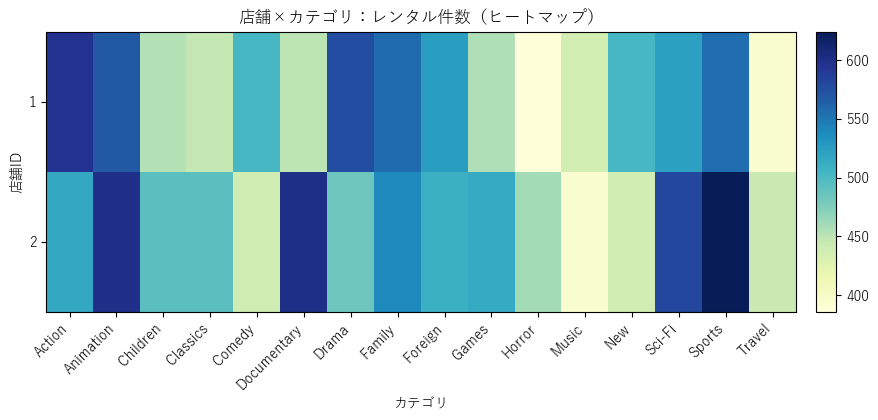

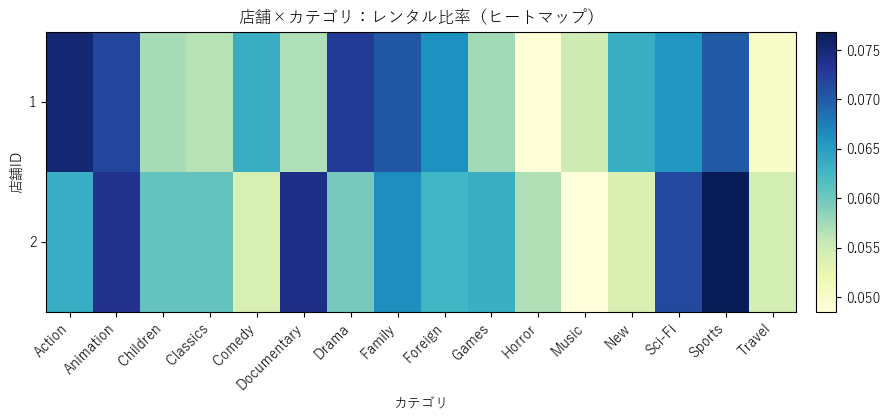

店舗ごとの強いジャンル（上位3）：
 store_id                                top_categories
        1       Action(596), Drama(576), Animation(568)
        2 Sports(624), Documentary(600), Animation(598)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

# ====== フォント設定（日本語対応） ======
rcParams["axes.unicode_minus"] = False
jp_candidates = [
    "Yu Gothic", "Meiryo", "MS Gothic",            # Windows
    "Hiragino Sans", "Hiragino Kaku Gothic ProN",  # macOS
    "Noto Sans CJK JP", "IPAGothic", "IPAexGothic" # Linux
]
installed = {f.name for f in fm.fontManager.ttflist}
for name in jp_candidates:
    if name in installed:
        rcParams["font.family"] = name
        break

# ====== CSVのパス ======
CAT_CSV   = "csv_exports/category.csv"
FC_CSV    = "csv_exports/film_category.csv"
FILM_CSV  = "csv_exports/film.csv"
INV_CSV   = "csv_exports/inventory.csv"
RENT_CSV  = "csv_exports/rental.csv"

# ====== 集計関数 ======
def make_store_category_counts():
    cat = pd.read_csv(CAT_CSV)
    fc  = pd.read_csv(FC_CSV)
    film= pd.read_csv(FILM_CSV)
    inv = pd.read_csv(INV_CSV)
    rent= pd.read_csv(RENT_CSV, parse_dates=["rental_date"])

    # rental -> inventory(店舗, film) -> film_category -> category
    df = (rent.merge(inv[["inventory_id","film_id","store_id"]], on="inventory_id", how="left")
              .merge(fc, on="film_id", how="left")
              .merge(cat, on="category_id", how="left"))

    pt_cnt = pd.pivot_table(df, index="store_id", columns="name",
                            values="rental_id", aggfunc="count", fill_value=0)
    pt_cnt = pt_cnt.sort_index().sort_index(axis=1)
    return pt_cnt

# ====== 可視化関数 ======
def plot_heatmap(table, title="店舗×カテゴリ：レンタル件数", figsize=(10,4)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.12, 0.2, 0.75, 0.7])
    im = ax.imshow(table.values, aspect="auto", cmap="YlGnBu")

    ax.set_xticks(range(table.shape[1]))
    ax.set_yticks(range(table.shape[0]))
    ax.set_xticklabels(table.columns, rotation=45, ha="right")
    ax.set_yticklabels(table.index)

    ax.set_xlabel("カテゴリ")
    ax.set_ylabel("店舗ID")
    ax.set_title(title)

    cax = fig.add_axes([0.89, 0.2, 0.02, 0.7])
    fig.colorbar(im, cax=cax)
    plt.show()

# ====== 上位カテゴリ表示 ======
def top_categories_per_store(table, top_n=3):
    rows = []
    for store_id, row in table.iterrows():
        top = row.sort_values(ascending=False).head(top_n)
        rows.append({
            "store_id": store_id,
            "top_categories": ", ".join(f"{k}({int(v)})" for k, v in top.items())
        })
    return pd.DataFrame(rows)

# ====== 実行 ======
if __name__ == "__main__":
    pt_cnt = make_store_category_counts()
    print("件数ピボット（先頭5行）：")
    print(pt_cnt.head(), "\n")

    # 件数ヒートマップ
    plot_heatmap(pt_cnt, title="店舗×カテゴリ：レンタル件数（ヒートマップ）")

    # 比率ヒートマップ
    pt_ratio = pt_cnt.div(pt_cnt.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    plot_heatmap(pt_ratio, title="店舗×カテゴリ：レンタル比率（ヒートマップ）")

    # 上位カテゴリ（各店舗）
    tops = top_categories_per_store(pt_cnt, top_n=3)
    print("店舗ごとの強いジャンル（上位3）：")
    print(tops.to_string(index=False))
